In [1]:
# !cat /proc/meminfo

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/HPDC22")

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import *

import copy
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

import seaborn as sns
sns.set_style("whitegrid")

current_palette = sns.color_palette("deep")

fontsize=25

import random

random.seed(10)

In [ ]:
def preprocess(dname, testing_ratio, level, shuffle=True):
    """
    testing ratio = 0.5, shuffle=False - for splitting the training and testing set by half;
    testing ratio = 0.01, shuffle=True - to shuffle the training dataset;
    testing_ratio = 0.99, shuffle=False - for inference;
    target: bp_0, bp_1, bp_2, bp_3, bp_4, all
    """
    df_features = pd.read_csv(dname)
    num_record = len(df_features)

    df_data_feature = df_features[["MaxErr", "z00","z01","z02","z03","z04","z05","z06","z07",
                                   "z10","z11","z12","z13","z14","z15","z16","z17",
                                   "z20","z21","z22","z23","z24","z25","z26","z27",
                                   "z30","z31","z32","z33","z34","z35","z36","z37",
                                   "z40","z41","z42","z43","z44","z45","z46","z47"]].copy() # "err_pred"
    df_data_target = df_features[["c0", "c1", "c2", "c3", "c4"]].copy()

    if level == 0:
        # df_data_feature = np.array(df_data_feature[["MaxErr","z00","z01","z02","z03","z04","z05","z06","z07"]].astype("float32"))
        df_data_feature = np.array(df_data_feature[["z00","z01","z02","z03","z04","z05","z06","z07"]].astype("float32"))
        df_data_target  = np.array(df_data_target[["c0"]].astype("float32"))
    elif level == 1:
        # df_data_feature = np.array(df_data_feature[["MaxErr","z10","z11","z12","z13","z14","z15","z16","z17"]].astype("float32"))
        df_data_feature = np.array(df_data_feature[["z10","z11","z12","z13","z14","z15","z16","z17"]].astype("float32"))
        df_data_target  = np.array(df_data_target[["c1"]].astype("float32"))
    elif level == 2:
        # df_data_feature = np.array(df_data_feature[["MaxErr","z20","z21","z22","z23","z24","z25","z26","z27"]].astype("float32"))
        df_data_feature = np.array(df_data_feature[["z20","z21","z22","z23","z24","z25","z26","z27"]].astype("float32"))
        df_data_target  = np.array(df_data_target[["c2"]].astype("float32"))
    elif level == 3:
        # df_data_feature = np.array(df_data_feature[["MaxErr","z30","z31","z32","z33","z34","z35","z36","z37"]].astype("float32"))
        df_data_feature = np.array(df_data_feature[["z30","z31","z32","z33","z34","z35","z36","z37"]].astype("float32"))
        df_data_target  = np.array(df_data_target[["c3"]].astype("float32"))
    elif level == 4:
        # df_data_feature = np.array(df_data_feature[["MaxErr","z40","z41","z42","z43","z44","z45","z46","z47"]].astype("float32"))
        df_data_feature = np.array(df_data_feature[["z40","z41","z42","z43","z44","z45","z46","z47"]].astype("float32"))
        df_data_target  = np.array(df_data_target[["c4"]].astype("float32"))


    df_training_feature = df_data_feature
    df_training_target = df_data_target

    X_train, X_test, Y_train, Y_test = train_test_split(df_training_feature, df_training_target, test_size=testing_ratio, shuffle=shuffle, random_state=233)
    
    normalizer = preprocessing.Normalizer()
    normalized_train_X = normalizer.fit_transform(X_train)
    normalized_test_X  = normalizer.transform(X_test)

    return normalized_train_X, normalized_test_X, Y_train, Y_test

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.wide = torch.nn.Sequential(
            torch.nn.Linear(8, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 1),
        )
        
    def forward(self, x):
        output = self.main(x)
        return output

class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
    
    def forward(self, prediction, target):
        return torch.nn.MSELoss()(prediction, target)

In [ ]:
def train(X_train, Y_train, num_epoch, learning_rate):

    x_train = Variable(torch.from_numpy(X_train))
    y_train = Variable(torch.from_numpy(Y_train))
    
    net = MLP().wide
    print(net)
    net = net.to("cuda")

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_func = MyLoss()

    BATCH_SIZE = 64
    EPOCH = num_epoch

    torch_dataset = Data.TensorDataset(x_train, y_train)

    loader = Data.DataLoader(
        dataset=torch_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=1,)
    
    # start training
    for epoch in range(EPOCH):
        for step, (batch_x, batch_y) in enumerate(loader): # for each training step
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            b_x = b_x.to("cuda")
            b_y = b_y.to("cuda")
            prediction = net(b_x)     # input x and predict based on x
            loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            
        if epoch % 100 == 0:
            print(loss.to("cpu").detach().numpy())
    return net

In [ ]:
def inference(feature, net, target):
    feature = Variable(torch.from_numpy(feature))
    target = Variable(torch.from_numpy(target))

    feature = feature.to("cuda")
    target = target.to("cuda")
    prediction = net(feature)
    return target.to("cpu").detach().numpy(), prediction.to("cpu").detach().numpy()

In [ ]:
# def validate_var(dname, net):
#     X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=0, shuffle=False)
#     target, prediction = inference(X_test, net, Y_test)

#     return target, prediction

In [ ]:
def predict(dname, net0, net1, net2, net3, net4):
    df_features = pd.read_csv(dname)

    df_data_feature = df_features[["z00","z01","z02","z03","z04","z05","z06","z07",
                                   "z10","z11","z12","z13","z14","z15","z16","z17",
                                   "z20","z21","z22","z23","z24","z25","z26","z27",
                                   "z30","z31","z32","z33","z34","z35","z36","z37",
                                   "z40","z41","z42","z43","z44","z45","z46","z47"]].copy() # "err_pred"
    features0 = Variable(torch.from_numpy(df_features[["z00", "z01", "z02", "z03", "z04", "z05", "z06", "z07"]].values[0]))
    features1 = Variable(torch.from_numpy(df_features[["z10", "z11", "z12", "z13", "z14", "z15", "z16", "z17"]].values[0]))
    features2 = Variable(torch.from_numpy(df_features[["z20", "z21", "z22", "z23", "z24", "z25", "z26", "z27"]].values[0]))
    features3 = Variable(torch.from_numpy(df_features[["z30", "z31", "z32", "z33", "z34", "z35", "z36", "z37"]].values[0]))
    features4 = Variable(torch.from_numpy(df_features[["z40", "z41", "z42", "z43", "z44", "z45", "z46", "z47"]].values[0]))

    return [net0(features0.float().to("cuda")).to("cpu").detach().numpy()[0],
            net1(features1.float().to("cuda")).to("cpu").detach().numpy()[0],
            net2(features2.float().to("cuda")).to("cpu").detach().numpy()[0],
            net3(features3.float().to("cuda")).to("cpu").detach().numpy()[0],
            net4(features4.float().to("cuda")).to("cpu").detach().numpy()[0]]
    

In [ ]:
if __name__ == "__main__":
    dname = "emgard_training_bx.csv"

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.3, level=0, shuffle=True)
    net0 = train(X_train, Y_train, num_epoch=1000, learning_rate=0.00001)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.3, level=1, shuffle=True)
    net1 = train(X_train, Y_train, num_epoch=1000, learning_rate=0.00001)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.3, level=2, shuffle=True)
    net2 = train(X_train, Y_train, num_epoch=1000, learning_rate=0.00001)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.3, level=3, shuffle=True)
    net3 = train(X_train, Y_train, num_epoch=1000, learning_rate=0.00001)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.3, level=4, shuffle=True)
    net4 = train(X_train, Y_train, num_epoch=1000, learning_rate=0.00001)

    # target, prediction = validate_var(dname, net)

Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=128, out_features=1, bias=True)
)
0.038428407
0.009587773
0.009830186
0.009597569
0.009832321
0.009021553
0.009830249
0.010119788
0.009339205
0.010064387
Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=128, out_features=1, bias=True)
)
0.094589874
0.009585659
0.009834947
0.01060688
0.009016453
0.01039435
0.0094133755
0.010345837
0.010112043
0.008860285
Sequential(
  (0): Linear(in_feat

In [ ]:
print(predict(dname, net0, net1, net2, net3, net4))

[0.24241745, 0.20159002, 0.2805241, 0.32888725, 0.33516517]


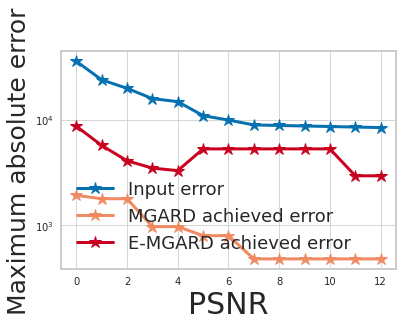

In [ ]:
fontsize = 30

# input_error_bx = [35700,31700,27700,23800,19800,15800,11900,7920,3960,
#                   3570,3170,2770,2380,1980,1580,1190,792,396,
#                   357,317,277,238,198,158,119,79.2,39.6,
#                   35.7,31.7,27.7,23.8,19.8,15.8,11.9,7.92,3.96,
#                   3.57,3.17,2.77,2.38,1.98,1.58,1.19,0.792,0.396,
#                   0.357,0.317,0.277,0.238,0.198,0.158,0.119,0.0792,0.0396,
#                   0.0357,0.0317,0.0277,0.0238,0.0198,0.0158,0.0119,0.00792,0.00396,
#                   0.00357,0.00317,0.00277,0.00238,0.00198,0.00158,0.00119,0.000792,0.000396,
#                   3.57E-04,3.17E-04,2.77E-04,2.38E-04,1.98E-04,1.58E-04,1.19E-04,7.92E-05,3.96E-05]

# emgard_error = [21648.6,21648.6,21648.6,21648.6,21648.6,21648.6,14244.7,10192.7,
#                 8679.9,8215.37,13197.3,13197.3,13197.3,13197.3,13197.3,13197.3,
#                 7337.79,7337.79,7337.79,7337.79,7337.79,3665.88,3665.88,3665.88,
#                 3637.24,3637.24,1915.69,1915.69,1780.95,969.252,479.259,473.088,
#                 410.035,412.488,257.968,257.968,202.693,131.227,110.92,55.167,
#                 55.167,36.056,36.056,36.056,27.9151,18.5127,18.5127,9.10505,
#                 4.91163,4.91163,4.91163,3.6659,3.6659,2.39332,2.39332,1.96585,
#                 0.933556,0.486086,0.486086,]

# mgard_error = [1915.69,1915.69,1915.69,1780.95,1780.95,969.252,795.717,479.259,267.562,
#                267.562,257.968,202.693,202.693,129.915,132.112,111.008,73.2511,27.9151,
#                27.9151,27.9151,18.5127,18.5127,18.5127,14.7019,7.35565,7.15062,3.64494,
#                3.29836,3.29836,1.96585,1.96585,1.96585,1.67065,0.928115,0.891311,0.421565,
#                0.419439,0.249461,0.249461,0.249461,0.233365,0.124082,0.124082,0.0549803,0.0276769,
#                0.0276769,0.0276769,0.0276769,0.0276769,0.0139885,0.0139885,0.0139885,0.00726964,0.00380429,
#                0.00380429,0.00380429,0.00359542,0.00190521,0.00190521,0.00190521,0.000923018,0.000923018,0.000494594,
#                0.000494594,0.000451409,0.000267171,0.000267171,0.000267171,0.000175347,0.000175347,0.000134824,0.000117307,
#                0.000117307,0.000117307,0.000117307,0.000117307,0.000117307,0.000117307,0.000117307,0.000117307,0.000117307,]

input_error_bx = [35700,23800,19800,15800,14800,10900,9900,8900,8800,8700,8600,8500,8400,]
emgard_error = [21648.6,14244.7,10192.7,8679.9,8215.37,13197.3,13197.3,13197.3,13197.3,13197.3,13197.3,7337.79,7337.79]
mgard_error = [1915.69,1780.95,1780.95,969.252,969.252,795.717,795.717,479.259,479.259,479.259,479.259,479.259,479.259,]
# psnr = []
emgard_error = np.array(emgard_error) / 2.5

psnr_bx = []

def plot_achieved_error(input_error, mgard_error, emgard_error, psnr):
    # plt.rcParams['text.usetex'] = True
    fig2, axs1 = plt.subplots(1, 1, figsize=(6, 4))

    axs1.plot(np.arange(len(input_error)),            input_error,   "-*", color="#0571b0", linewidth=3, markersize=12, label="Input error")
    axs1.plot(np.arange(len(mgard_error)),   np.array(mgard_error),  "-*", color="#ef8a62", linewidth=3, markersize=12, label="MGARD achieved error")
    axs1.plot(np.arange(len(emgard_error)), np.array(emgard_error), "-*", color="#ca0020", linewidth=3, markersize=12, label="E-MGARD achieved error")

    # axs1.set_xticks(np.arange(len(psnr[0:-1:4])), psnr[0:-1:4])
    # axs1.set_xticklabels(psnr[0:-1:4], fontsize=fontsize, rotation=90)

    axs1.set_yscale("log")
    # axs1.set_yticks([1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5])
    # axs1.set_yticklabels(["1E-5", "1E-3", "1E-1", "1E+1", "1E+3", "1E+5"], fontsize=fontsize)

    axs1.set_xlabel("PSNR", fontsize=fontsize)
    axs1.set_ylabel("Maximum absolute error", fontsize=25)
    axs1.legend(loc='lower left', bbox_to_anchor=(0, 0), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=18)

    # axs1.spines["bottom"].set_color("black")
    # axs1.spines["top"].set_color("black") 
    # axs1.spines["right"].set_color("black")
    # axs1.spines["left"].set_color("black")
    

plot_achieved_error(input_error_bx, mgard_error, emgard_error, psnr_bx)